In [2]:
import emcee
import corner
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)
from statistics_functions import chi_squared

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [39]:
data = pd.read_csv('data/reflex70.txt', header=7, sep='|', skiprows=[range(6), 8],on_bad_lines='warn', skipfooter=1, skipinitialspace=True).rename(columns=lambda x: x.strip())
#data = data.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
#data['Name'].values.strip()
data = data.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
#data['Name']

mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=1).rename(columns=lambda x: x.strip())
mcxccls = mcxccls.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
mcxc_data = mcxccls[mcxccls['Sub-Cat']=='REFLEX'][['OName','AName', 'L500']].rename(columns={'AName': 'Name'})
#mcxc_data

L500s=[]
ObsLum_mcxc=[]
for name in mcxc_data['Name']:
    L500s.append(mcxc_data[mcxc_data['Name']==name]['L500'].values[0])
    ObsLum_mcxc.append(data[data['Name']==name]['ObsLum'].values)
    
mcxc_data_clean=mcxc_data.dropna()
data_clean=data[['RXC', 'Name', 'Flux', 'e_Flux', 'ObsLum', 'LumCor', 'z']].dropna()

comb = pd.merge(mcxc_data_clean, data_clean, left_on='OName', right_on='RXC', how='inner', sort=True)
comb

/var/folders/99/vfh56jrs1nqcj8zqtcs5fkv40000gn/T/ipykernel_36826/1597049447.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv('data/reflex70.txt', header=7, sep='|', skiprows=[range(6), 8],on_bad_lines='warn', skipfooter=1, skipinitialspace=True).rename(columns=lambda x: x.strip())
/var/folders/99/vfh56jrs1nqcj8zqtcs5fkv40000gn/T/ipykernel_36826/1597049447.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=1).rename(columns=lambda x: x.strip())


,OName,Name_x,L500,RXC,Name_y,Flux,e_Flux,ObsLum,LumCor,z
0,RXCJ0003.1-0605,A2697,6.107094,RXCJ0003.1-0605,A2697,4.497,12.4,6.395,6.876,0.2320
1,RXCJ0003.2-3555,A2717,0.441862,RXCJ0003.2-3555,A2717,7.537,17.8,0.421,0.478,0.0490
2,RXCJ0003.8+0203,A2700,0.846881,RXCJ0003.8+0203,A2700,4.155,18.8,0.855,0.929,0.0924
3,RXCJ0006.0-3443,A2721,1.809494,RXCJ0006.0-3443,A2721,5.832,13.6,1.875,1.995,0.1147
4,RXCJ0011.3-2851,A2734,1.086002,RXCJ0011.3-2851,A2734,12.014,9.0,1.089,1.197,0.0620
...,...,...,...,...,...,...,...,...,...,...
330,RXCJ2351.6-2605,A2667,11.968015,RXCJ2351.6-2605,A2667,9.295,10.1,12.422,13.651,0.2264
331,RXCJ2354.2-1024,A2670,1.336537,RXCJ2354.2-1024,A2670,9.622,12.1,1.337,1.469,0.0765
332,RXCJ2357.0-3445,A4059,1.629622,RXCJ2357.0-3445,A4059,32.663,5.5,1.698,1.787,0.0475
333,RXCJ2359.3-6042,A4067,1.051539,RXCJ2359.3-6042,A4067,4.544,20.5,1.080,1.149,0.0989


In [40]:
(comb['OName'].tolist())

['RXCJ0003.1-0605',
 'RXCJ0003.2-3555',
 'RXCJ0003.8+0203',
 'RXCJ0006.0-3443',
 'RXCJ0011.3-2851',
 'RXCJ0013.6-1930',
 'RXCJ0014.3-3023',
 'RXCJ0014.3-6604',
 'RXCJ0017.5-3509',
 'RXCJ0020.7-2542',
 'RXCJ0025.5-3302',
 'RXCJ0027.3-5015',
 'RXCJ0028.6-2338',
 'RXCJ0040.1-5607',
 'RXCJ0041.8-0918',
 'RXCJ0042.1-2832',
 'RXCJ0043.4-2037',
 'RXCJ0049.4-2931',
 'RXCJ0052.7-8015',
 'RXCJ0056.3-0112',
 'RXCJ0057.8-6648',
 'RXCJ0102.7-2152',
 'RXCJ0105.5-2439',
 'RXCJ0106.8-0229',
 'RXCJ0107.8-3643',
 'RXCJ0108.1+0210',
 'RXCJ0108.8-1524',
 'RXCJ0108.9-1537',
 'RXCJ0110.0-4555',
 'RXCJ0115.2+0019',
 'RXCJ0118.1-2658',
 'RXCJ0120.9-1351',
 'RXCJ0125.6-0124',
 'RXCJ0131.8-1336',
 'RXCJ0145.0-5300',
 'RXCJ0145.2-6033',
 'RXCJ0152.9-1345',
 'RXCJ0157.4-0550',
 'RXCJ0201.7-0212',
 'RXCJ0202.3-0107',
 'RXCJ0206.4-1453',
 'RXCJ0211.4-4017',
 'RXCJ0216.7-4749',
 'RXCJ0225.9-4154',
 'RXCJ0230.7-3305',
 'RXCJ0231.9+0114',
 'RXCJ0236.6-1923',
 'RXCJ0237.4-2630',
 'RXCJ0248.0-0332',
 'RXCJ0249.6-3111',


In [41]:
d_L = cosmo.comoving_distance(comb['z']).to(u.m).value #(return meters)
#flux_var=ufloat(comb['Flux'].to_numpy(), comb['e_Flux'].to_numpy())
#Lobs_calc=(comb['Flux'].to_numpy()*u.W*1e-15/u.m**2 * 4*np.pi * d_L**2).to(u.W)
flux_arr=comb['Flux'].to_numpy()*1e-15 # to get in watts
eflux_arr=comb['e_Flux'].to_numpy()
flux_var=np.array([ufloat(flux_arr[i],eflux_arr[i]*flux_arr[i]/100) for i in range(len(flux_arr))])

#originally in units u.W*1e-15/u.m**2 * Mpc**2
Lobs_calc=(flux_var*4*np.pi*d_L**2) * 1e-37 

#Lobs_calc #now in units of 1e37 W
Lobs_err = [L.std_dev for L in Lobs_calc]
#Lobs_err
Lobs_calc

array([4.752562089465066+/-0.5893176990936682,
       0.38834767216514743+/-0.06912588564539625,
       0.745922576900713+/-0.14023344445733404,
       1.5962288643873468+/-0.21708712555667914,
       0.9850814005299323+/-0.0886573260476939,
       1.1271051139128871+/-0.12736287787215625,
       8.819902024182403+/-1.6493216785221092,
       2.333867767423409+/-0.3220737519044305,
       0.6313363763523621+/-0.12626727527047243,
       2.4135326772236376+/-0.2920374539440601,
       0.45618706030144873+/-0.04425014484924054,
       1.8425238329482687+/-0.3150715754341539,
       1.2636774736720755+/-0.16806910399838607,
       0.06764484627114607+/-0.013055455330331192,
       4.890977692536981+/-0.1565112861611834,
       2.3879872138694673+/-0.2340227469592078,
       5.186387949672107+/-0.8090765201488487,
       1.2819104194925146+/-0.20510566711880232,
       3.0516866429031273+/-0.6469575682954628,
       1.4123668858975584+/-0.0748554449525706,
       0.6720610432210038+/-0.241

In [42]:
# MCMC: L_o=(L_c - b)/m 
# change to L_o=(L500-b)/m
L_obs_data = comb['ObsLum']
L_obs_var=[L.std_dev for L in Lobs_calc]
#L_cor=comb['LumCor']
L500=comb['L500']

Text(0, 0.5, 'L500')

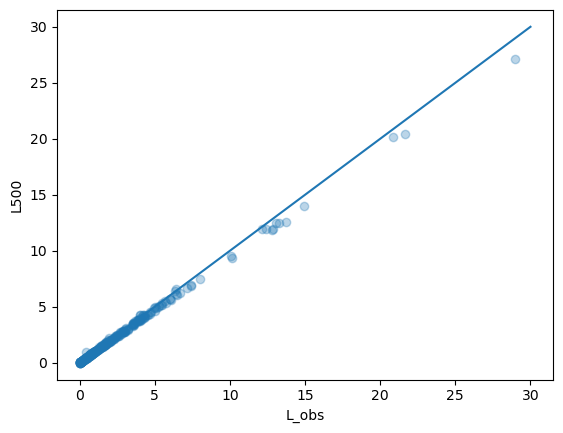

In [43]:
plt.scatter(L_obs_data, L500, alpha=0.3)
plt.plot(np.linspace(0,30), np.linspace(0,30))
plt.xlabel('L_obs')
plt.ylabel('L500')

In [44]:
def log_lik(p0, L_c, obs, var):
    m=p0[0]
    if np.abs(m)<0.00001:
        return -np.inf
    b=p0[1]
    if np.abs(m)>10 or np.abs(b)>10:
        return -np.inf
    pred=(L_c-b)/m
    return -1*chi_squared(pred, obs, var)/2

In [45]:
p0=[1, 0]
log_lik(p0, L500, L_obs_data, L_obs_var)

-1560.26343236444

In [46]:
ndim=2
nwalkers = 32
guess=(1, 0)
p0 = guess+np.random.normal(scale=0.1, size=(nwalkers, ndim))
p0

array([[ 1.09996948e+00, -1.37653169e-01],
       [ 8.51785594e-01, -4.81863641e-04],
       [ 1.02162617e+00, -4.92658796e-02],
       [ 9.57719224e-01,  6.94354321e-02],
       [ 9.75052886e-01,  4.63742794e-02],
       [ 9.66166696e-01,  1.48107226e-01],
       [ 9.90369574e-01,  5.35963998e-02],
       [ 1.00406264e+00,  1.54421818e-01],
       [ 9.57426118e-01,  1.15569502e-01],
       [ 7.67646849e-01, -1.12682829e-01],
       [ 9.27567426e-01, -2.46649388e-01],
       [ 8.86003202e-01, -4.48909054e-02],
       [ 1.04159634e+00, -1.56474988e-01],
       [ 1.00839643e+00,  1.09509591e-01],
       [ 1.05395644e+00,  3.62547409e-02],
       [ 8.89799222e-01,  2.02816622e-02],
       [ 7.63998554e-01, -2.33747274e-02],
       [ 1.14445875e+00, -1.17129283e-02],
       [ 9.47739043e-01,  2.88669592e-02],
       [ 1.05230169e+00,  7.81257725e-03],
       [ 1.09402086e+00,  2.18571871e-01],
       [ 1.04775478e+00, -1.81417502e-01],
       [ 9.09853328e-01, -6.73253872e-02],
       [ 9.

In [47]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_lik, args=[L500, L_obs_data, L_obs_var])

In [48]:
state = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 31.48it/s]


In [49]:
sampler.run_mcmc(state, 5000, progress=True)

100%|███████████████████████████████████████| 5000/5000 [02:40<00:00, 31.21it/s]


State([[1.05165663 0.00382235]
 [1.04826358 0.00401442]
 [1.0520131  0.00337596]
 [1.03945792 0.0039994 ]
 [1.05852006 0.00393279]
 [1.04920956 0.00390063]
 [1.04659771 0.00392039]
 [1.04692683 0.00387914]
 [1.04785579 0.00347855]
 [1.05247545 0.00369915]
 [1.04353189 0.00389399]
 [1.06076167 0.00378772]
 [1.05010095 0.00387704]
 [1.05317455 0.00380918]
 [1.04731974 0.00389455]
 [1.04715651 0.00368698]
 [1.04861282 0.00399546]
 [1.05166179 0.00403368]
 [1.04930012 0.00423274]
 [1.04172731 0.00379162]
 [1.05323552 0.00357266]
 [1.05104238 0.00399469]
 [1.04675678 0.00375305]
 [1.05219493 0.00371088]
 [1.04641999 0.0041675 ]
 [1.05394703 0.0041392 ]
 [1.04937896 0.00443675]
 [1.03994679 0.00402624]
 [1.05155085 0.00391711]
 [1.04667939 0.00406102]
 [1.04279473 0.00406186]
 [1.05499944 0.00377377]], log_prob=[-1173.21341219 -1173.30073317 -1177.62014966 -1174.67658598
 -1175.09526668 -1172.99274586 -1173.05086293 -1173.0103444
 -1175.98549181 -1173.78900444 -1173.43053203 -1175.92245807
 

In [50]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

(160000, 2)


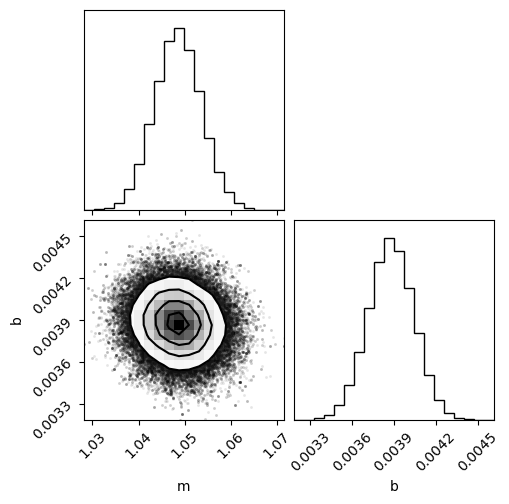

In [51]:
fig = corner.corner(flat_samples, labels=['m', 'b']) 

In [52]:
sampler.get_chain()

array([[[1.05271105, 0.00380733],
        [1.05005978, 0.00376206],
        [1.05458692, 0.00332163],
        ...,
        [1.04785462, 0.0041461 ],
        [1.04245743, 0.00393029],
        [1.04276463, 0.00401586]],

       [[1.05086922, 0.00378137],
        [1.04994444, 0.00369742],
        [1.05399131, 0.00334297],
        ...,
        [1.0467177 , 0.00427737],
        [1.04245743, 0.00393029],
        [1.04276463, 0.00401586]],

       [[1.05086922, 0.00378137],
        [1.04994444, 0.00369742],
        [1.05399131, 0.00334297],
        ...,
        [1.0467177 , 0.00427737],
        [1.04281281, 0.00392528],
        [1.04276463, 0.00401586]],

       ...,

       [[1.05241837, 0.00355312],
        [1.04351941, 0.00410047],
        [1.0520131 , 0.00337596],
        ...,
        [1.04442731, 0.00417944],
        [1.04032352, 0.0042185 ],
        [1.05564972, 0.00382936]],

       [[1.05354965, 0.00349268],
        [1.04351941, 0.00410047],
        [1.0520131 , 0.00337596],
        .

In [53]:
tau = sampler.get_autocorr_time()
print(tau)

[30.07013866 30.70599743]


In [54]:
np.median(flat_samples[:,0]), np.median(flat_samples[:,1])

(1.048516651338926, 0.0038772099493464694)

In [55]:
m_err=np.var(flat_samples[:,0]) # var=mean((p-pmean)**2)
m_err

2.5501184566886655e-05

In [56]:
b_err=np.var(flat_samples[:,1])
b_err

2.7129123183675346e-08

In [57]:
m_uf=ufloat(np.median(flat_samples[:,0]), np.var(flat_samples[:,0]))
b_uf=ufloat(np.median(flat_samples[:,1]), np.var(flat_samples[:,1]))

m_uf, b_uf # uncertainty too small??

(1.048516651338926+/-2.5501184566886655e-05,
 0.0038772099493464694+/-2.7129123183675346e-08)

In [58]:
L_obs_uf=unp.uarray(comb['ObsLum'], [L.std_dev for L in Lobs_calc])

L500_pred=m_uf*L_obs_uf+b_uf

In [59]:
L500_uf=unp.uarray(comb['L500'], [L.std_dev for L in L500_pred])
L500_uf

array([6.107094+/-0.6179094419486882, 0.441862+/-0.07247964293288481,
       0.846881+/-0.14703710320470523, 1.809494+/-0.22761947095956642,
       1.086002+/-0.09295868677236488, 1.236332+/-0.13354210223189258,
       11.818114+/-1.7293412740877763, 2.827248+/-0.3376996999677323,
       0.692442+/-0.1323933419454966, 2.872451+/-0.3062061422609284,
       0.49467+/-0.04639701540882626, 2.164603+/-0.33035779817579547,
       1.404549+/-0.1762232582198019, 0.072779+/-0.013688862424430896,
       5.100085+/-0.1641047451727569, 2.734146+/-0.24537675727894,
       6.907787+/-0.8483302244986201, 1.438047+/-0.21505671067355567,
       3.393306+/-0.6783457890981536, 1.437223+/-0.07848718985966151,
       0.734662+/-0.2536801907396271, 1.460216+/-0.0925488665939969,
       5.160525+/-0.6647784187183639, 2.779734+/-0.5185702798856171,
       1.156778+/-0.14815067083837766, 0.192363+/-0.029975509553122483,
       0.491051+/-0.04290117582179534, 0.815085+/-0.11727147208361945,
       0.181484+/-0.

In [60]:
L_errs = [L.std_dev for L in L500_pred]
len(L_errs)

335

In [61]:
comb['OName']

0      RXCJ0003.1-0605
1      RXCJ0003.2-3555
2      RXCJ0003.8+0203
3      RXCJ0006.0-3443
4      RXCJ0011.3-2851
            ...       
330    RXCJ2351.6-2605
331    RXCJ2354.2-1024
332    RXCJ2357.0-3445
333    RXCJ2359.3-6042
334    RXCJ2359.9-3928
Name: OName, Length: 335, dtype: object

In [62]:
dict_name_err = dict(zip(comb['OName'], L_errs))

In [63]:
dict_name_err['RXCJ0011.3-2851']

0.09295868677236488

In [64]:
import pickle
with open('data/REFLEX.p', 'wb') as fp:
    pickle.dump(dict_name_err, fp)

In [65]:
dict_name_err

{'RXCJ0003.1-0605': 0.6179094419486882,
 'RXCJ0003.2-3555': 0.07247964293288481,
 'RXCJ0003.8+0203': 0.14703710320470523,
 'RXCJ0006.0-3443': 0.22761947095956642,
 'RXCJ0011.3-2851': 0.09295868677236488,
 'RXCJ0013.6-1930': 0.13354210223189258,
 'RXCJ0014.3-3023': 1.7293412740877763,
 'RXCJ0014.3-6604': 0.3376996999677323,
 'RXCJ0017.5-3509': 0.1323933419454966,
 'RXCJ0020.7-2542': 0.3062061422609284,
 'RXCJ0025.5-3302': 0.04639701540882626,
 'RXCJ0027.3-5015': 0.33035779817579547,
 'RXCJ0028.6-2338': 0.1762232582198019,
 'RXCJ0040.1-5607': 0.013688862424430896,
 'RXCJ0041.8-0918': 0.1641047451727569,
 'RXCJ0042.1-2832': 0.24537675727894,
 'RXCJ0043.4-2037': 0.8483302244986201,
 'RXCJ0049.4-2931': 0.21505671067355567,
 'RXCJ0052.7-8015': 0.6783457890981536,
 'RXCJ0056.3-0112': 0.07848718985966151,
 'RXCJ0057.8-6648': 0.2536801907396271,
 'RXCJ0102.7-2152': 0.0925488665939969,
 'RXCJ0105.5-2439': 0.6647784187183639,
 'RXCJ0106.8-0229': 0.5185702798856171,
 'RXCJ0107.8-3643': 0.148150670